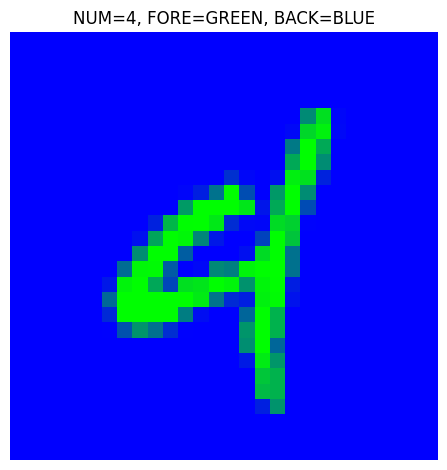

In [7]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(mnist))  # 0~9 사이의 숫자
image, label = mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

In [8]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# 1. 데이터 분할
# 데이터를 평탄화 (flatten)하여 RandomForest에서 사용할 수 있도록 변환
X_color_flat = X_color.reshape(X_color.shape[0], -1)

# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 2. Random Forest 모델 학습 및 검증
# 모델 초기화
rf_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 학습 및 시간 측정
start_fg = time.time()
rf_fg.fit(X_train, y_fg_train)
end_fg = time.time()

start_bg = time.time()
rf_bg.fit(X_train, y_bg_train)
end_bg = time.time()

start_digit = time.time()
rf_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = rf_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = rf_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = rf_digit.predict(X_val)
val_end_digit = time.time()

# 3. 정확도 계산
accuracy_fg = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg = end_fg - start_fg
training_time_bg = end_bg - start_bg
training_time_digit = end_digit - start_digit

validation_time_fg = val_end_fg - val_start_fg
validation_time_bg = val_end_bg - val_start_bg
validation_time_digit = val_end_digit - val_start_digit

# 4. 결과 출력
print(f"Raw Data")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit:.2f} 초")


X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)
(60000, 2352)
Raw Data
Random Forest 전경 색상(fg) 정확도: 0.9996
Random Forest 전경 색상(fg) 학습 시간: 53.12 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.24 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 16.10 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.08 초
Random Forest 숫자(digit) 정확도: 0.9331
Random Forest 숫자(digit) 학습 시간: 88.07 초
Random Forest Validation 숫자(digit) 예측 시간: 0.40 초


In [ ]:
# Data Binarization

In [ ]:
import numpy as np
from PIL import ImageOps
from torchvision import datasets, transforms
from PIL import Image

# 무작위로 사용할 색상 팔레트 정의
RAINBOW_COLORS = [
    (255, 0, 0),   # Red
    (255, 127, 0), # Orange
    (255, 255, 0), # Yellow
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (75, 0, 130),  # Indigo
    (143, 0, 255)  # Violet
]
RAINBOW_NAMES = ["Red", "Orange", "Yellow", "Green", "Blue", "Indigo", "Violet"]

# 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

# 무작위 색상 선택 함수
def get_random_rainbow_color():
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

# 이진화 후 색상을 입히는 함수
def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 이진화 후 전경(fg)과 배경(bg) 색상을 적용합니다."""
    # 이미지를 그레이스케일로 변환 및 이진화
    digit = digit_image.convert('L')
    threshold = 127
    digit = digit.point(lambda p: 255 if p > threshold else 0)  # 이진화 적용

    # 전경과 배경 색상 적용
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

# 데이터셋에 색상을 입히고 전처리
for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상 선택 (서로 다른 색상으로 설정)
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 이진화 후 전경 및 배경 색상이 적용된 숫자 이미지 생성
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

# 리스트를 Numpy 배열로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")


X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# 1. 데이터 분할
# 데이터를 평탄화 (flatten)하여 RandomForest에서 사용할 수 있도록 변환
X_color_flat = X_color.reshape(X_color.shape[0], -1)

# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 2. Random Forest 모델 학습 및 검증
# 모델 초기화
rf_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 학습 및 시간 측정
start_fg = time.time()
rf_fg.fit(X_train, y_fg_train)
end_fg = time.time()

start_bg = time.time()
rf_bg.fit(X_train, y_bg_train)
end_bg = time.time()

start_digit = time.time()
rf_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = rf_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = rf_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = rf_digit.predict(X_val)
val_end_digit = time.time()

# 3. 정확도 계산
accuracy_fg_binarization = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg_binarization = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit_binarization = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg_binarization = end_fg - start_fg
training_time_bg_binarization = end_bg - start_bg
training_time_digit_binarization = end_digit - start_digit

validation_time_fg_binarization = val_end_fg - val_start_fg
validation_time_bg_binarization = val_end_bg - val_start_bg
validation_time_digit_binarization = val_end_digit - val_start_digit

# 4. 결과 출력
print(f"Data Binarization")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_binarization:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_binarization:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg_binarization:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_binarization:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_binarization:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg_binarization:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_binarization:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_binarization:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit_binarization:.2f} 초")


Data Binarization
Random Forest 전경 색상(fg) 정확도: 1.0000
Random Forest 전경 색상(fg) 학습 시간: 42.41 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.24 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 15.19 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.09 초
Random Forest 숫자(digit) 정확도: 0.9239
Random Forest 숫자(digit) 학습 시간: 91.06 초
Random Forest Validation 숫자(digit) 예측 시간: 0.49 초


In [3]:
#Data Min Max Scaler

In [4]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 평탄화 (flatten)
X_color_flattened = X_color.reshape(-1, 28 * 28 * 3)

# 훈련, 테스트 데이터 분할 (90% 훈련+검증, 10% 테스트)
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flattened, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련, 검증 데이터 분할 (90% 훈련, 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 정규화 (훈련 데이터 기준으로 fit)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 최종 데이터 형태 확인
print(f"훈련 데이터 크기: {X_train_scaled.shape}")
print(f"검증 데이터 크기: {X_val_scaled.shape}")
print(f"테스트 데이터 크기: {X_test_scaled.shape}")


훈련 데이터 크기: (48600, 2352)
검증 데이터 크기: (5400, 2352)
테스트 데이터 크기: (6000, 2352)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# RandomForest 모델 초기화
rf_model_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 전경 색상(fg) 학습 및 시간 측정
start_time_fg = time.time()
rf_model_fg.fit(X_train_scaled, y_fg_train)
end_time_fg = time.time()

# 배경 색상(bg) 학습 및 시간 측정
start_time_bg = time.time()
rf_model_bg.fit(X_train_scaled, y_bg_train)
end_time_bg = time.time()

# 숫자(digit) 학습 및 시간 측정
start_time_digit = time.time()
rf_model_digit.fit(X_train_scaled, y_digit_train)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = rf_model_fg.predict(X_val_scaled)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = rf_model_bg.predict(X_val_scaled)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = rf_model_digit.predict(X_val_scaled)
end_time_digit_val = time.time()

# 학습 및 예측 시간 계산
training_time_fg_MinMax = end_time_fg - start_time_fg
training_time_bg_MinMax = end_time_bg - start_time_bg
training_time_digit_MinMax = end_time_digit - start_time_digit

validation_time_fg_MinMax = end_time_fg_val - start_time_fg_val
validation_time_bg_MinMax = end_time_bg_val - start_time_bg_val
validation_time_digit_MinMax = end_time_digit_val - start_time_digit_val

# 정확도 계산
accuracy_fg_rf_MinMax = accuracy_score(y_fg_val, y_val_fg_pred)
accuracy_bg_rf_MinMax = accuracy_score(y_bg_val, y_val_bg_pred)
accuracy_digit_rf_MinMax = accuracy_score(y_digit_val, y_val_digit_pred)

# 결과 출력
print(f"Data Min-Max Scaling with Random Forest")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf_MinMax:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_MinMax:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg_MinMax:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf_MinMax:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_MinMax:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg_MinMax:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf_MinMax:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_MinMax:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit_MinMax:.2f} 초")


Data Min-Max Scaling with Random Forest
Random Forest 전경 색상(fg) 정확도: 0.9996
Random Forest 전경 색상(fg) 학습 시간: 53.91 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.18 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 16.63 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.08 초
Random Forest 숫자(digit) 정확도: 0.9313
Random Forest 숫자(digit) 학습 시간: 88.31 초
Random Forest Validation 숫자(digit) 예측 시간: 0.35 초


In [ ]:
#Data grayscale

In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [ ]:
# X_color 배열을 그레이스케일로 변환
X_color_gray = []

for img in X_color:
    # RGB 이미지를 Grayscale로 변환
    gray_image = Image.fromarray(img).convert('L')
    X_color_gray.append(np.array(gray_image))

X_color_gray = np.array(X_color_gray)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# 1. 데이터 준비 및 평탄화
# 그레이스케일 데이터의 형태: (n_samples, height, width)
# 평탄화: (n_samples, height * width)
X_color_gray_flat = X_color_gray.reshape(X_color_gray.shape[0], -1)

# 2. 데이터 분할
# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_gray_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 3. Random Forest 모델 학습
# 모델 초기화
rf_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 학습 및 시간 측정 - 전경 색상(fg)
start_fg = time.time()
rf_fg.fit(X_train, y_fg_train)
end_fg = time.time()

# 학습 및 시간 측정 - 배경 색상(bg)
start_bg = time.time()
rf_bg.fit(X_train, y_bg_train)
end_bg = time.time()

# 학습 및 시간 측정 - 숫자(digit)
start_digit = time.time()
rf_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 4. 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = rf_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = rf_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = rf_digit.predict(X_val)
val_end_digit = time.time()

# 5. 정확도 계산
accuracy_fg_grayscale = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg_grayscale = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit_grayscale = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg_grayscale = end_fg - start_fg
training_time_bg_grayscale = end_bg - start_bg
training_time_digit_grayscale = end_digit - start_digit

validation_time_fg_grayscale = val_end_fg - val_start_fg
validation_time_bg_grayscale = val_end_bg - val_start_bg
validation_time_digit_grayscale = val_end_digit - val_start_digit

# 6. 결과 출력
print(f"Data Gray Scale")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_grayscale:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_grayscale:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg_grayscale:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_grayscale:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_grayscale:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg_grayscale:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_grayscale:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_grayscale:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit_grayscale:.2f} 초")


Data Gray Scale
Random Forest 전경 색상(fg) 정확도: 0.9883
Random Forest 전경 색상(fg) 학습 시간: 54.68 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.25 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 14.93 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.07 초
Random Forest 숫자(digit) 정확도: 0.9281
Random Forest 숫자(digit) 학습 시간: 86.15 초
Random Forest Validation 숫자(digit) 예측 시간: 0.40 초


In [ ]:
print(f"Raw Data")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit:.2f} 초")

print(f"Data Binarization")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_binarization:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_binarization:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg_binarization:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_binarization:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_binarization:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg_binarization:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_binarization:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_binarization:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit_binarization:.2f} 초")

print(f"Data Min-Max Scaling")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf_MinMax:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_MinMax:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {training_time_fg_val_MinMax:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf_MinMax:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_MinMax:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {training_time_bg_val_MinMax:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf_MinMax:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_MinMax:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {training_time_digit_val_MinMax:.2f} 초")

print(f"Data Gray Scale")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_grayscale:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg_grayscale:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg_grayscale:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_grayscale:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg_grayscale:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg_grayscale:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_grayscale:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit_grayscale:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit_grayscale:.2f} 초")

Raw Data
Random Forest 전경 색상(fg) 정확도: 0.9996
Random Forest 전경 색상(fg) 학습 시간: 62.14 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.21 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 19.44 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.08 초
Random Forest 숫자(digit) 정확도: 0.9331
Random Forest 숫자(digit) 학습 시간: 104.69 초
Random Forest Validation 숫자(digit) 예측 시간: 0.58 초
Data Binarization
Random Forest 전경 색상(fg) 정확도: 1.0000
Random Forest 전경 색상(fg) 학습 시간: 42.41 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.24 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 15.19 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.09 초
Random Forest 숫자(digit) 정확도: 0.9239
Random Forest 숫자(digit) 학습 시간: 91.06 초
Random Forest Validation 숫자(digit) 예측 시간: 0.49 초
Data Min-Max Scaling
Random Forest 전경 색상(fg) 정확도: 1.0000
Random Forest 전경 색상(fg) 학습 시간: 56.29 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.48 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 17.03 초
Random F

In [ ]:
#데이터 전처리 결과 GrayScale은 이미 색깔을 입힐때 이미 적용하였으므로 한번더 적용하였기 때문에 오히려 성능저하
# MinMaxScaling은 RF모델에 부적합
#데이터 이진화는 오히려 학습할때 Noise성분이 없어지므로 Digit을 구분하는데에 있어서는 방해가 되므로 성능이 낮아졌을 거라고 추측합니다.

#그러나 정확도를 제외하고는 학습시간,검증시간을 고려해봤을때에는 데이터전처리를 사용한 이후 학습시간이 줄어드는 것을 확인 여러번 시도하면 학습시간이 달라지나 digit 학습시간을 고려해봤을때 15초,20초 차이는 크다.